1

> 1  
> Goal of the project  
> Reproduce the results from the paper "Predicting the direction of
> stock market prices using random forest."  
> Import Libraries

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>%matplotlib inline<br />
import matplotlib.pyplot as plt<br />
plt.rcParams['figure.figsize'] = (7,4.5) <em># Make the default figures
a bit bigger</em></p>
<p>import numpy as np<br />
import random</p>
<p><em>#Let's make this notebook reproducible</em>
np.random.seed(42)<br />
random.seed(42)</p>
<p>import pandas_techinal_indicators as ta
<em>#https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/</em><br />
<em>technical_indicators.py</em></p>
<p>import pandas as pd<br />
from sklearn.ensemble import RandomForestClassifier</p>
<p>from sklearn.metrics import f1_score, precision_score,
confusion_matrix, recall_score, accuracy_score<br />
from sklearn.model_selection import train_test_split</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Data  
> In order to reproduce the same results as the authors, we try to use
> the same data they used in page 18, table 15.
>
> Since the authors state that they compare these results with other
> authors using the data from yahoo finance in the period \[2010-01-04
> to 2014-12-10\] we will use the same data. It is not clear which
> periods they used as traning set and testing set.

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>aapl = pd.read_csv('AAPL.csv')<br />
del(aapl['Date'])<br />
del(aapl['Adj Close'])<br />
aapl.head()</p>
</blockquote>
<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>Open High Low Close Volume 0 33.641430 33.801430 33.494286 33.571430
107664900 1 33.915714 34.104286 33.250000 33.709999 150786300 2
33.568573 34.072857 33.538570 34.070000 171126900 3 34.028572 34.320000
33.857143 34.220001 111754300 4 34.221428 34.560001 34.094284 34.371429
157125500</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Exponential smoothing
>
> The authors don't give any guideline for alpha, so let's assume it is
> 0.9

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>def get_exp_preprocessing(df, alpha=0.9): edata =
df.ewm(alpha=alpha).mean() return edata</p>
<p>saapl = get_exp_preprocessing(aapl)<br />
saapl.head() <em>#saapl stands for smoothed aapl</em></p>
</blockquote>
<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>Open High Low Close Volume 0 33.641430 33.801430 33.494286 33.571430
1.076649e+08 1 33.890779 34.076754 33.272208 33.697402 1.468662e+08 2
33.600503 34.073243 33.512174 34.033076 1.687227e+08 3 33.985804
34.295347 33.822677 34.201325 1.174460e+08 4 34.197868 34.533538
34.067126 34.354420 1.531579e+08</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Feature Extraction - Technical Indicators
>
> It's not very clear what 'n' should be in most of the indicators, so,
> we are using several values of 'n'
>
> note: the Williams %R indicator does not seem to be available in this
> library yet

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>def feature_extraction(data):<br />
for x in [5, 14, 26, 44, 66]:<br />
data = ta.relative_strength_index(data, n=x) data =
ta.stochastic_oscillator_d(data, n=x) data =
ta.accumulation_distribution(data, n=x)</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>data = ta.average_true_range(data, n=x)<br />
data = ta.momentum(data, n=x)<br />
data = ta.money_flow_index(data, n=x)<br />
data = ta.rate_of_change(data, n=x)<br />
data = ta.on_balance_volume(data, n=x)<br />
data = ta.commodity_channel_index(data, n=x) data =
ta.ease_of_movement(data, n=x)<br />
data = ta.trix(data, n=x)<br />
data = ta.vortex_indicator(data, n=x)</p>
<p>data['ema50'] = data['Close'] / data['Close'].ewm(50).mean()
data['ema21'] = data['Close'] / data['Close'].ewm(21).mean()
data['ema14'] = data['Close'] / data['Close'].ewm(14).mean()
data['ema5'] = data['Close'] / data['Close'].ewm(5).mean()</p>
<p><em>#Williams %R is missing</em><br />
data = ta.macd(data, n_fast=12, n_slow=26)</p>
<p>del(data['Open'])<br />
del(data['High'])<br />
del(data['Low'])<br />
del(data['Volume'])</p>
<p>return data</p>
<p>def compute_prediction_int(df, n):<br />
pred = (df.shift(-n)['Close'] &gt;= df['Close']) pred =
pred.iloc[:-n]<br />
return pred.astype(int)</p>
<p>def prepare_data(df, horizon):<br />
data = feature_extraction(df).dropna().iloc[:-horizon] data['pred'] =
compute_prediction_int(data, n=horizon) del(data['Close'])<br />
return data.dropna()</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Prepare the data with a prediction horizon of 10 days

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>data = prepare_data(saapl, 10)</p>
<p>y = data['pred']</p>
<p><em>#remove the output from the input</em><br />
features = [x for x in data.columns if x notin ['gain', 'pred']] X =
data[features]</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Make sure that future data is not used by splitting the data in first
> 2/3 for training and the last 1/3 for testing

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>train_size = 2*len(X) // 3</p>
<p>X_train = X[:train_size]<br />
X_test = X[train_size:]<br />
y_train = y[:train_size]<br />
y_test = y[train_size:]</p>
<p>print('len X_train', len(X_train))<br />
print('len y_train', len(y_train))<br />
print('len X_test', len(X_test))<br />
print('len y_test', len(y_test))</p>
<p>len X_train 644<br />
len y_train 644<br />
len X_test 323<br />
len y_test 323</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Random Forests

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>rf = RandomForestClassifier(n_jobs=-1, n_estimators=65,
random_state=42)<br />
rf.fit(X_train, y_train.values.ravel());</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> The expected results for a 10 days prediction according to the paper
> in table 15 for Apple stock should be around 92%

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>pred = rf.predict(X_test)<br />
precision = precision_score(y_pred=pred, y_true=y_test)<br />
recall = recall_score(y_pred=pred, y_true=y_test)<br />
f1 = f1_score(y_pred=pred, y_true=y_test)<br />
accuracy = accuracy_score(y_pred=pred, y_true=y_test)<br />
confusion = confusion_matrix(y_pred=pred, y_true=y_test)<br />
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy:
{3:1.2f}'.format(precision, recall, f1, accuracy))<br />
print('Confusion Matrix')<br />
print(confusion)</p>
<p>precision: 0.66, recall: 0.68, f1: 0.67, accuracy: 0.58 Confusion
Matrix<br />
[[ 47 71]<br />
[ 66 139]]</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> However, the resulting accuracy is 58% ! Some plots for intuition of
> what is going on

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>plt.figure(figsize=(20,7))<br />
plt.plot(np.arange(len(pred)), pred, label='pred')<br />
plt.plot(np.arange(len(y_test)), y_test, label='real' );
plt.title('Prediction versus reality in the test set') plt.legend();</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> <img
> src="attachment:vertopal_e9c4fc18ac2b4c5f82c40cb8264bdb42/media/image1.png"
> style="width:6.49861in;height:2.40139in" />

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>plt.figure(figsize=(20,7))<br />
proba = rf.predict_proba(X_test)[:,1]<br />
plt.figure(figsize=(20,7))<br />
plt.plot(np.arange(len(proba)), proba, label='pred_probability')
plt.plot(np.arange(len(y_test)), y_test, label='real' );<br />
plt.title('Prediction probability versus reality in the test set');
plt.legend();<br />
plt.show();</p>
<p>&lt;matplotlib.figure.Figure at 0x1fec5d7a908&gt;</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> <img
> src="attachment:vertopal_e9c4fc18ac2b4c5f82c40cb8264bdb42/media/image2.png"
> style="width:6.49861in;height:2.4in" />

|     |
|-----|

> Let's now duplicate the analysis for the case where the test set is
> shuffled
>
> This means that there is **data leakage** in the training set, as the
> future and the past are together in the training and testing sets

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>X_train, X_test, y_train, y_test = train_test_split(X, y, train_size
= 2*len(X) // 3)</p>
<p>print('len X_train', len(X_train))<br />
print('len y_train', len(y_train))<br />
print('len X_test', len(X_test))<br />
print('len y_test', len(y_test))</p>
<p>len X_train 644<br />
len y_train 644<br />
len X_test 323<br />
len y_test 323</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> Let's use Random Forests with data leaked data set

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>rf = RandomForestClassifier(n_jobs=-1, n_estimators=65,
random_state=42)<br />
rf.fit(X_train, y_train.values.ravel());</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> The expected results for a 10 days prediction according to the paper
> in table 15 for Apple stock should be around 92%

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>pred = rf.predict(X_test)<br />
precision = precision_score(y_pred=pred, y_true=y_test)<br />
recall = recall_score(y_pred=pred, y_true=y_test)<br />
f1 = f1_score(y_pred=pred, y_true=y_test)<br />
accuracy = accuracy_score(y_pred=pred, y_true=y_test)<br />
confusion = confusion_matrix(y_pred=pred, y_true=y_test)<br />
print('precision: {0:1.2f}, recall: {1:1.2f}, f1: {2:1.2f}, accuracy:
{3:1.2f}'.format(precision, recall, f1, accuracy))<br />
print('Confusion Matrix')<br />
print(confusion)</p>
<p>precision: 0.87, recall: 0.91, f1: 0.89, accuracy: 0.87 Confusion
Matrix<br />
[[117 25]<br />
[ 16 165]]</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> The accuracy results almost match those expected from the paper 87% vs
> the expected 92%

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>plt.figure(figsize=(20,7))<br />
plt.plot(np.arange(len(pred)), pred, alpha=0.7, label='pred')<br />
plt.plot(np.arange(len(y_test)), y_test, alpha=0.7, label='real' );
plt.title('Prediction versus reality in the test set - Using Leaked
data')<br />
plt.legend();</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> <img
> src="attachment:vertopal_e9c4fc18ac2b4c5f82c40cb8264bdb42/media/image3.png"
> style="width:6.49861in;height:2.40139in" />

<table>
<colgroup>
<col style="width: 100%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>plt.figure(figsize=(20,7))<br />
proba = rf.predict_proba(X_test)[:,1]<br />
plt.figure(figsize=(20,7))<br />
plt.plot(np.arange(len(proba)), proba, alpha = 0.7,<br />
label='pred_probability')<br />
plt.plot(np.arange(len(y_test)), y_test, alpha = 0.7, label='real' );
plt.title('Prediction probability versus reality in the test set - Using
Leaked data');<br />
plt.legend();<br />
plt.show();</p>
<p>&lt;matplotlib.figure.Figure at 0x1fec591be10&gt;</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> <img
> src="attachment:vertopal_e9c4fc18ac2b4c5f82c40cb8264bdb42/media/image4.png"
> style="width:6.49861in;height:2.40139in" />
>
> Comments on Data Leaked results
>
> The results with the data leakage approach are much more in line with
> those reported by the paper. In the paper it was reported a 92%
> accuracy for Apple, while this analysis yields 87% instead. This could
> be for a number of reasons including:

<table>
<colgroup>
<col style="width: 50%" />
<col style="width: 50%" />
</colgroup>
<thead>
<tr class="header">
<th><blockquote>
<p>•<br />
•<br />
•</p>
</blockquote>
<p>•</p></th>
<th><blockquote>
<p>the feature Williams %R was not computed<br />
the value for alpha was set to 0.9, but we don't know what alpha was
used<br />
the value n for several of the technical indicators was not known, and
we opted for try several values for 'n'<br />
more technical indicators were used in the hope that they could
contribute to even better results</p>
</blockquote></th>
</tr>
</thead>
<tbody>
</tbody>
</table>

> This analysis seems to indicate that the results from the original
> paper suffer from data leakage. Please, let me know if you notice any
> mistake in the analysis / code or if you feel there is something I
> misunderstood.

|     |
|-----|
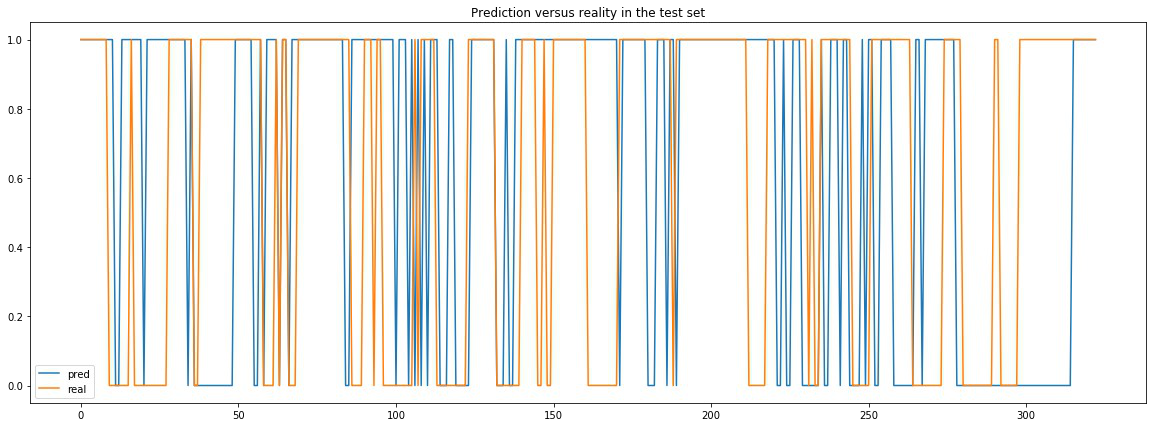
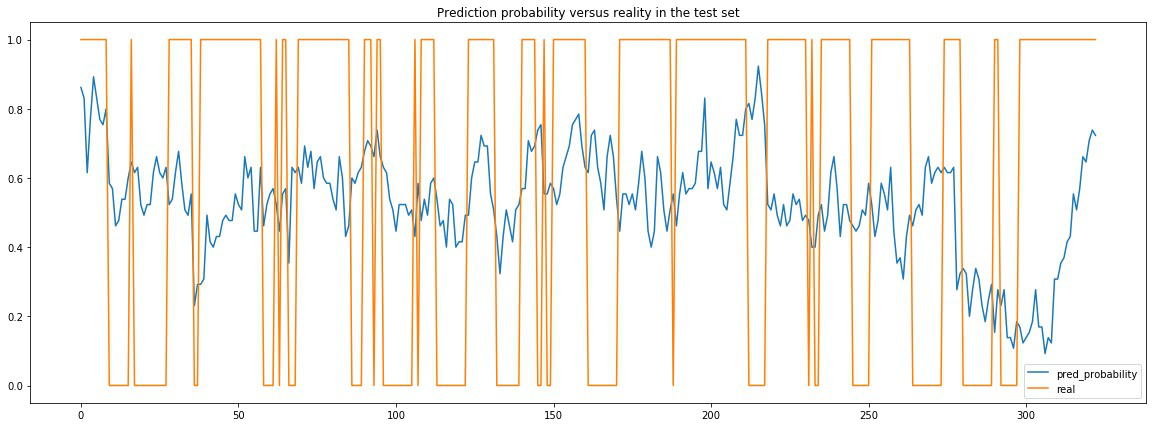
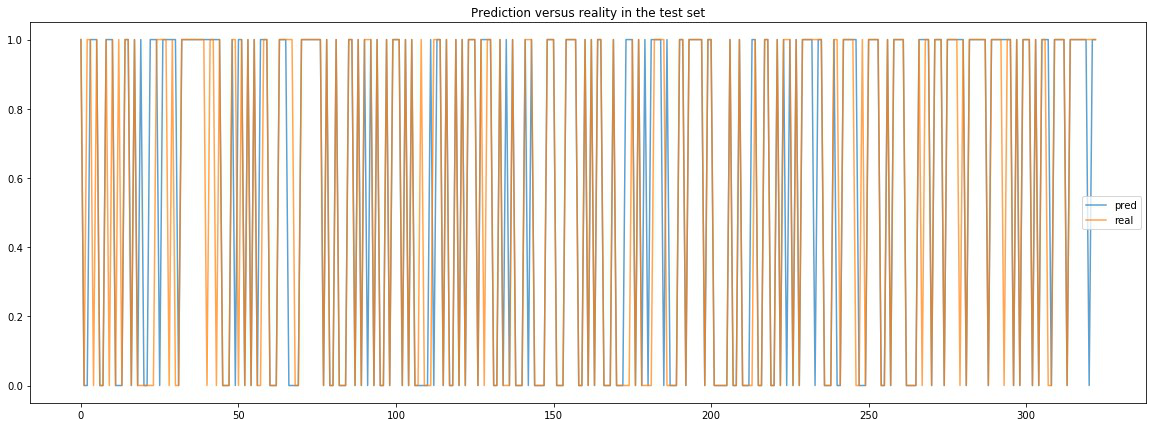
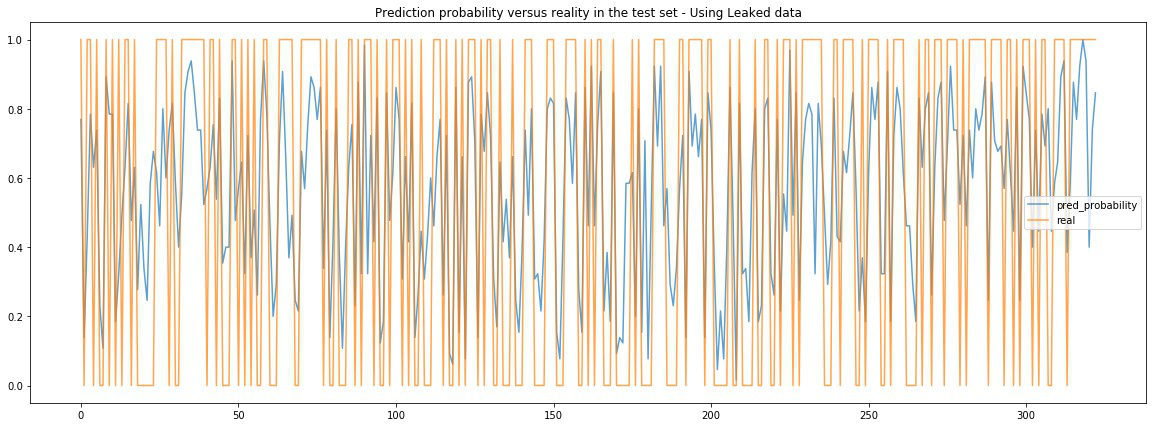